# Introduction

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import warnings
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

# EDA

In [2]:
df = pd.read_csv("train.csv")
df.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


check if Target is balanced

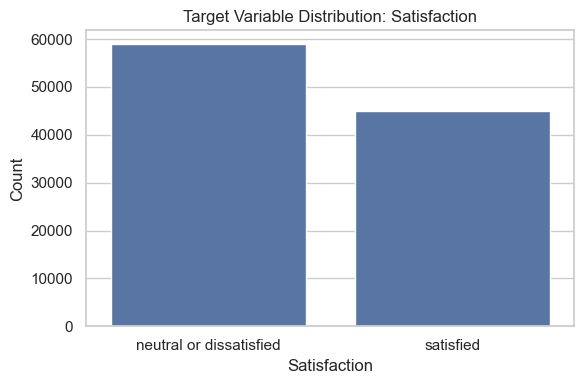

In [3]:
plt.figure(figsize=(6, 4))
sns.countplot(x="satisfaction", data=df)
plt.title("Target Variable Distribution: Satisfaction")
plt.xlabel("Satisfaction")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

The dataset is slightly imbalanced: more users are “neutral or dissatisfied” than “satisfied”.

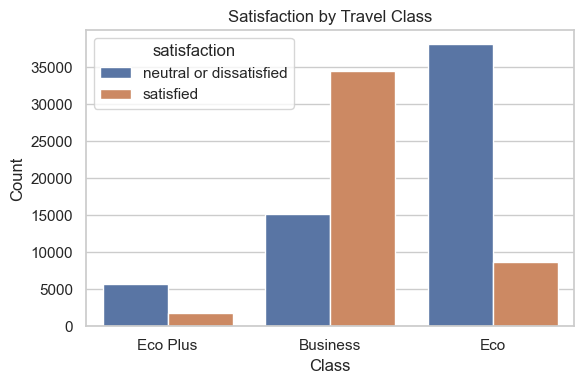

In [4]:
# Class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x="Class", data=df, hue="satisfaction")
plt.title("Satisfaction by Travel Class")
plt.xlabel("Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

*Business class passengers tend to be more satisfied.

*Economy class passengers are mostly dissatisfied.

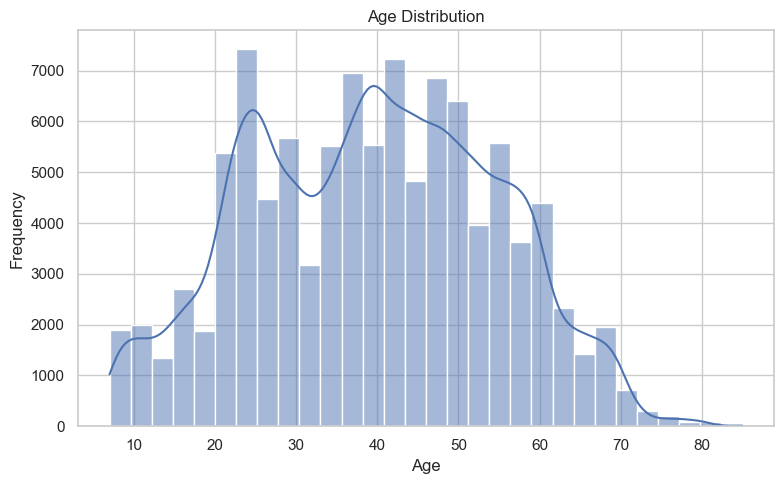

In [5]:
# Age distribution
plt.figure(figsize=(8, 5))
sns.histplot(df["Age"], bins=30, kde=True)
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

Most passengers are between 20 and 60 years old

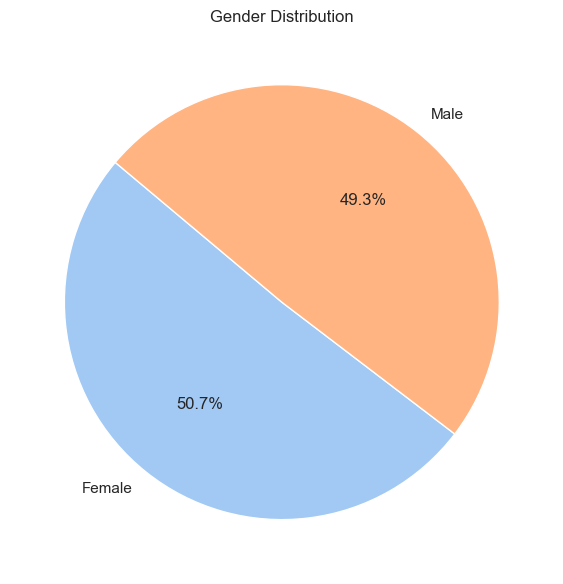

In [6]:
gender_counts = df['Gender'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("pastel"))
plt.title("Gender Distribution")
plt.tight_layout()
plt.show()

Fairly balanced distribution between Male and Female as the percentages are very close to each other. 

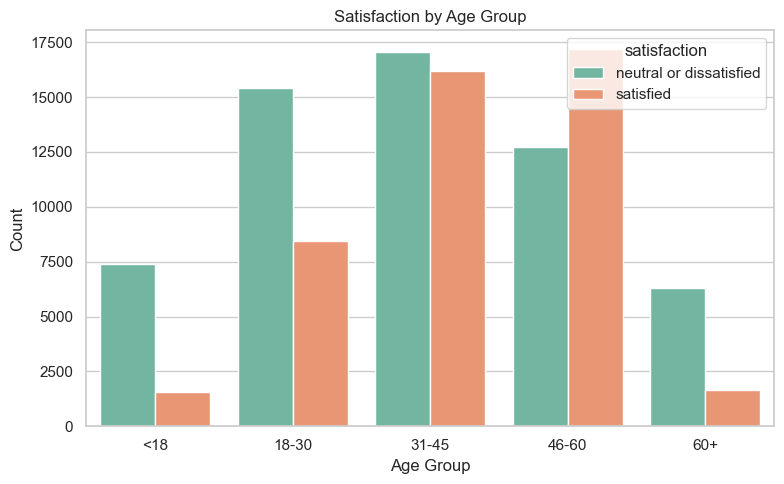

In [7]:
# Create a new column for age groups
df['Age Group'] = pd.cut(df['Age'], bins=[0, 18, 30, 45, 60, 100], 
                         labels=['<18', '18-30', '31-45', '46-60', '60+'])

# Satisfaction by Age Group
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Age Group', hue='satisfaction', palette='Set2')
plt.title("Satisfaction by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

Younger passengers (<30) tend to report more dissatisfaction.

Older age groups (especially 31–60) show higher satisfaction rates.

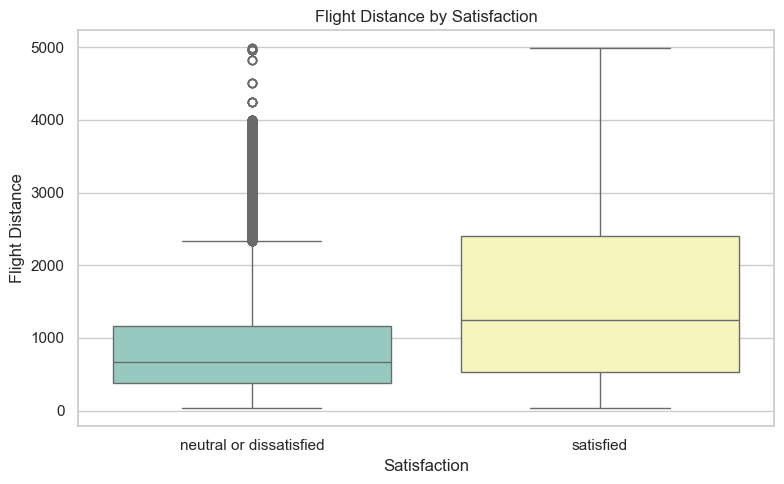

In [8]:
# Boxplot of Flight Distance vs Satisfaction
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='satisfaction', y='Flight Distance', palette='Set3')
plt.title("Flight Distance by Satisfaction")
plt.xlabel("Satisfaction")
plt.ylabel("Flight Distance")
plt.tight_layout()
plt.show()

Satisfied passengers generally have longer flight distances.

Dissatisfaction tends to cluster around shorter flights.

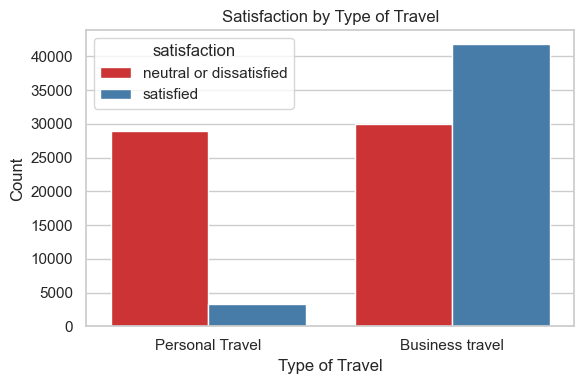

In [9]:
# Satisfaction by Type of Travel
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="Type of Travel", hue="satisfaction", palette="Set1")
plt.title("Satisfaction by Type of Travel")
plt.xlabel("Type of Travel")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

Business travel passengers are more satisfied.

Personal travel passengers tend to be more dissatisfied.

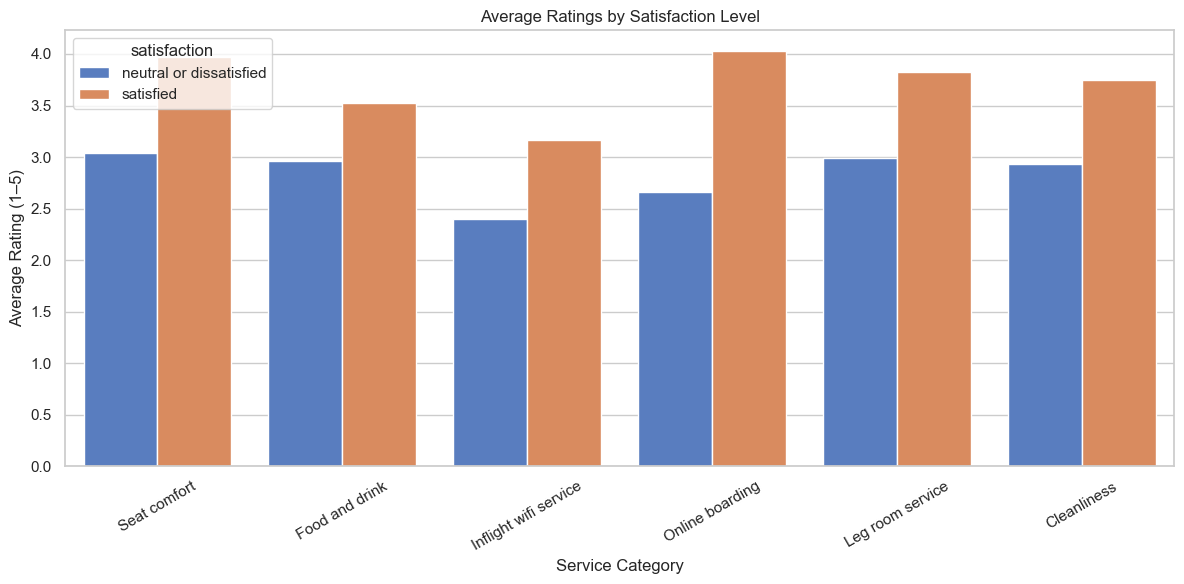

In [10]:
# Select a few rating-related columns to analyze
rating_cols = [
    "Seat comfort", "Food and drink", "Inflight wifi service",
    "Online boarding", "Leg room service", "Cleanliness"
]

# Melt the data for seaborn barplot
df_melted = df.melt(id_vars=["satisfaction"], value_vars=rating_cols,
                    var_name="Service", value_name="Rating")

# Average Rating by Satisfaction for each Service
plt.figure(figsize=(12, 6))
sns.barplot(data=df_melted, x="Service", y="Rating", hue="satisfaction", ci=None, palette="muted")
plt.title("Average Ratings by Satisfaction Level")
plt.xticks(rotation=30)
plt.ylabel("Average Rating (1–5)")
plt.xlabel("Service Category")
plt.tight_layout()
plt.show()


This bar chart shows the average rating (1–5) of several airline services, separately for satisfied and dissatisfied customers.

Each service (like Seat comfort, Food and drink, etc.) has two bars:

One for passengers who were satisfied

One for those who were neutral or dissatisfied

For Seat comfort, the “satisfied” group gave an average rating around 4

The “dissatisfied” group gave around 3

# Preprocessing

Shape of data (103904, 25)

In [11]:
data = pd.read_csv('train.csv')
data.shape

(103904, 25)

In [12]:
data.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


- first 2 columns are useless
- categorical features Gender, Customer Type, Type of Travel, Class, satisfaction
- Target satisfication 

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         103904 non-null  int64  
 1   id                                 103904 non-null  int64  
 2   Gender                             103904 non-null  object 
 3   Customer Type                      103904 non-null  object 
 4   Age                                103904 non-null  int64  
 5   Type of Travel                     103904 non-null  object 
 6   Class                              103904 non-null  object 
 7   Flight Distance                    103904 non-null  int64  
 8   Inflight wifi service              103904 non-null  int64  
 9   Departure/Arrival time convenient  103904 non-null  int64  
 10  Ease of Online booking             103904 non-null  int64  
 11  Gate location                      1039

In [14]:
data = data.drop(columns=['Unnamed: 0', 'id'], axis=1)

In [15]:
for col in data.columns:
    print(f"{col}: {data[col].unique()}")

Gender: ['Male' 'Female']
Customer Type: ['Loyal Customer' 'disloyal Customer']
Age: [13 25 26 61 47 52 41 20 24 12 53 33 45 38  9 17 43 58 23 57 49 36 22 31
 15 35 67 37 40 34 39 50 29 54 21 28 27 69 60 48 59 46 30 66 64 44 51 32
 19 42 16 11 62  8 56 68 55 18 65 72 70 63 10  7 14 80 74 71 85 73 76 77
 75 79 78]
Type of Travel: ['Personal Travel' 'Business travel']
Class: ['Eco Plus' 'Business' 'Eco']
Flight Distance: [ 460  235 1142 ...  974 1479  400]
Inflight wifi service: [3 2 4 1 5 0]
Departure/Arrival time convenient: [4 2 5 3 1 0]
Ease of Online booking: [3 2 5 4 1 0]
Gate location: [1 3 2 5 4 0]
Food and drink: [5 1 2 4 3 0]
Online boarding: [3 5 2 1 4 0]
Seat comfort: [5 1 2 3 4 0]
Inflight entertainment: [5 1 2 3 4 0]
On-board service: [4 1 2 3 5 0]
Leg room service: [3 5 4 2 1 0]
Baggage handling: [4 3 5 1 2]
Checkin service: [4 1 3 5 2 0]
Inflight service: [5 4 3 1 2 0]
Cleanliness: [5 1 2 3 4 0]
Departure Delay in Minutes: [  25    1    0   11    9    4   28   43   49    

In [16]:
data.describe()

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
count,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103594.000000
mean,39.379706,1189.448375,2.729683,3.060296,2.756901,2.976883,3.202129,3.250375,3.439396,3.358158,3.382363,3.351055,3.631833,3.304290,3.640428,3.286351,14.815618,15.178678
std,15.114964,997.147281,1.327829,1.525075,1.398929,1.277621,1.329533,1.349509,1.319088,1.332991,1.288354,1.315605,1.180903,1.265396,1.175663,1.312273,38.230901,38.698682
min,7.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,414.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000
50%,40.000000,843.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.000000,0.000000
75%,51.000000,1743.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,12.000000,13.000000
max,85.000000,4983.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1592.000000,1584.000000


- Arival delay has 310 nulls 
- probably meaning no dealy so could be set to zero
  but could be missing 
- I will be imputing with median anyway it is qual to zero


In [17]:
data.isnull().sum()

Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             310
satisfaction                           0
dtype: int64

In [18]:
data['Arrival Delay in Minutes'].fillna(data['Arrival Delay in Minutes'].median(), inplace=True)

Target is kinda balanced

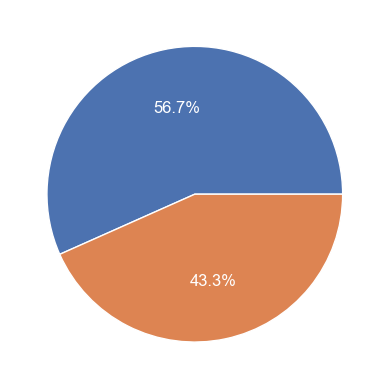

In [19]:
plt.figure(facecolor='none')
plt.pie(
    data.satisfaction.value_counts(),
    labels=["Neutral or dissatisfied", "Satisfied"],
    autopct='%1.1f%%',
    textprops={'color': 'white'}
)
plt.show()
pass

Label encoding categorical features

































In [20]:
data['satisfaction'] = data['satisfaction'].map({'satisfied': 1, 'neutral or dissatisfied': 0})
data['Gender'] = data['Gender'].map({'Male':1, 'Female':0})
data['Customer Type'] = data['Customer Type'].map({'Loyal Customer':1, 'disloyal Customer':0})
data['Type of Travel'] = data['Type of Travel'].map({'Business travel':1, 'Personal Travel':0})
data['Class'] = data['Class'].map({'Eco':0, 'Eco Plus':1, 'Business':2})

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Gender                             103904 non-null  int64  
 1   Customer Type                      103904 non-null  int64  
 2   Age                                103904 non-null  int64  
 3   Type of Travel                     103904 non-null  int64  
 4   Class                              103904 non-null  int64  
 5   Flight Distance                    103904 non-null  int64  
 6   Inflight wifi service              103904 non-null  int64  
 7   Departure/Arrival time convenient  103904 non-null  int64  
 8   Ease of Online booking             103904 non-null  int64  
 9   Gate location                      103904 non-null  int64  
 10  Food and drink                     103904 non-null  int64  
 11  Online boarding                    1039

convert data to int16 and float16 size 18.2 -> 4 MB

In [22]:
# convert all int64 to int16
for col in data.select_dtypes(include=['int64']).columns:
    data[col] = data[col].astype('int16')

# convert all float64 to float32
for col in data.select_dtypes(include=['float64']).columns:
    data[col] = data[col].astype('float16')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Gender                             103904 non-null  int16  
 1   Customer Type                      103904 non-null  int16  
 2   Age                                103904 non-null  int16  
 3   Type of Travel                     103904 non-null  int16  
 4   Class                              103904 non-null  int16  
 5   Flight Distance                    103904 non-null  int16  
 6   Inflight wifi service              103904 non-null  int16  
 7   Departure/Arrival time convenient  103904 non-null  int16  
 8   Ease of Online booking             103904 non-null  int16  
 9   Gate location                      103904 non-null  int16  
 10  Food and drink                     103904 non-null  int16  
 11  Online boarding                    1039

## correlation analysis

<Axes: >

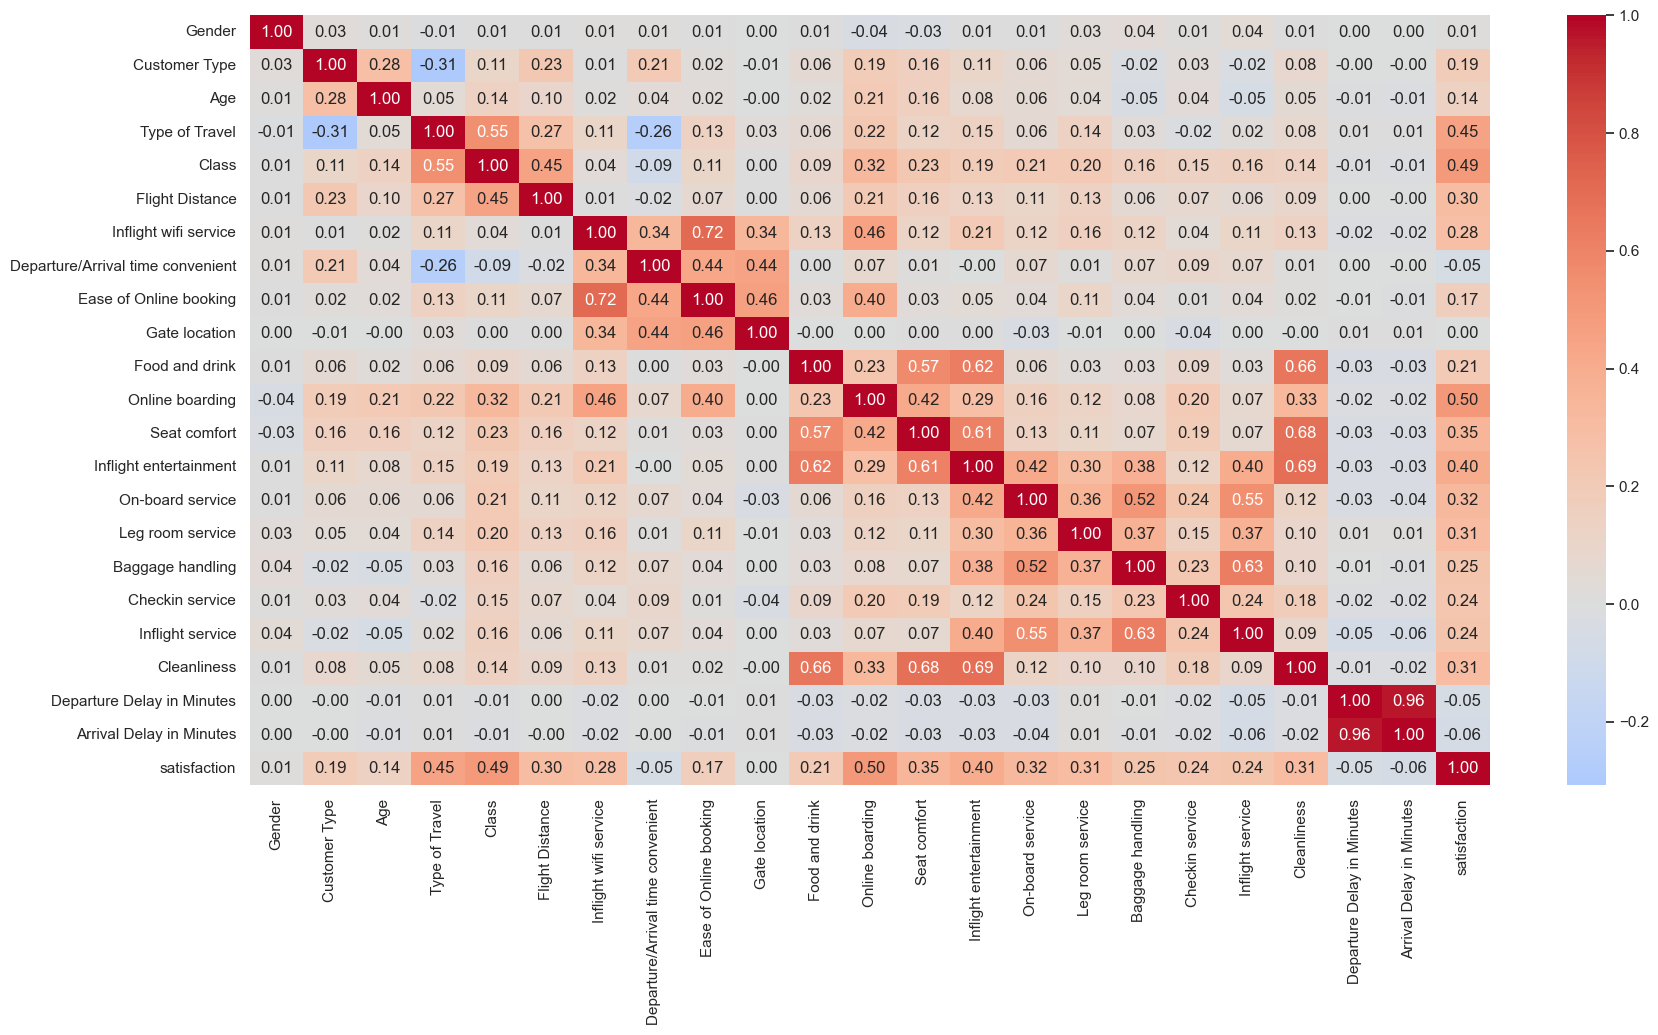

In [23]:
corr = data.corr()

plt.figure(figsize=(20, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0)

## scale data and split features from target

In [24]:
# scaling data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x = data.drop(columns=['satisfaction'], axis=1)
y = data['satisfaction'].values
scaled_x = scaler.fit_transform(x)
scaled_x = pd.DataFrame(scaled_x, columns=x.columns)
scaled_x.head()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
0,1.015031,0.472767,-1.745279,-1.490614,-0.029187,-0.731539,0.203579,0.616172,0.173776,-1.547323,...,1.183099,1.231704,0.479403,-0.266840,0.311769,0.549799,1.156436,1.305870,0.266393,0.074169
1,1.015031,-2.115208,-0.951360,0.670865,1.009393,-0.957184,0.203579,-0.695245,0.173776,0.018094,...,-1.849314,-1.769081,-1.849161,1.253381,-0.535045,-1.821012,0.305848,-1.742292,-0.361375,-0.236313
2,-0.985192,0.472767,-0.885200,0.670865,1.009393,-0.047584,-0.549533,-0.695245,-0.541060,-0.764614,...,1.183099,1.231704,0.479403,-0.266840,0.311769,0.549799,0.305848,1.305870,-0.387532,-0.391554
3,-0.985192,0.472767,-0.951360,0.670865,1.009393,-0.629246,-0.549533,1.271880,1.603448,1.583511,...,-1.091211,-1.018885,-1.072973,1.253381,-0.535045,-1.821012,0.305848,-0.980251,-0.099805,-0.158692
4,1.015031,0.472767,1.430397,0.670865,1.009393,-0.978244,0.203579,-0.039537,0.173776,0.018094,...,1.183099,-0.268688,-0.296785,0.493270,0.311769,-0.240472,-0.544740,-0.218211,-0.387532,-0.391554


# Feature Engineering

## Filter Methods : variance & Correlation

In [26]:
def variance_feature_selection(df, threshold=0.5, target_column='satisfaction'):
    """
    Remove features with variance below the threshold.

    Parameters:
        df (pd.DataFrame): Scaled dataframe.
        threshold (float): Variance threshold.

    Returns:
        pd.DataFrame: DataFrame with selected features.
    """
    feature_df = df.drop(columns=target_column)
    variances = feature_df.var()
    low_variance_features = variances[variances < threshold].index.tolist()

    selected_df = df.drop(columns=low_variance_features)

    return selected_df, low_variance_features

def correlation_feature_selection(df, threshold=0.9, target_column='satisfaction'):
    """
    Remove highly correlated features, keeping the one more correlated with the target.

    Parameters:
        df (pd.DataFrame): Scaled dataframe including target column.
        threshold (float): Correlation threshold between features.
        target_column (str): Name of the target column.

    Returns:
        pd.DataFrame: DataFrame with selected features and target.
    """
    df = df.copy()
    corr_matrix = df.corr().abs()

    # Exclude target from feature-feature correlation
    feature_corr = corr_matrix.drop(index=target_column, columns=target_column)
    target_corr = corr_matrix[target_column]

    # Find highly correlated pairs
    upper = feature_corr.where(np.triu(np.ones(feature_corr.shape), k=1).astype(bool))
    high_corr_pairs = [(col1, col2) for col1 in upper.columns for col2 in upper.index
                       if pd.notnull(upper.loc[col2, col1]) and upper.loc[col2, col1] > threshold]

    # Decide which to drop based on target correlation
    to_drop = set()
    for f1, f2 in high_corr_pairs:
        if target_corr[f1] >= target_corr[f2]:
            to_drop.add(f2)
        else:
            to_drop.add(f1)

    # Keep target column
    selected_columns = [col for col in df.columns if col not in to_drop]
    return df[selected_columns], list(to_drop)


In [27]:
var_df, var_dropped = variance_feature_selection(data, threshold=0.1)
print(f"Low variance features dropped: {var_dropped}")

Low variance features dropped: ['Arrival Delay in Minutes']


In [28]:
corr_df, corr_dropped = correlation_feature_selection(data, threshold=0.6)
print(f"Highly correlated features dropped: {corr_dropped}")

Highly correlated features dropped: ['Food and drink', 'Seat comfort', 'Departure Delay in Minutes', 'Ease of Online booking', 'Cleanliness', 'Inflight service']


- Low variance features could be dropped: ['Arrival Delay in Minutes']
- Highly correlated features could be dropped: ['Food and drink', 'Seat comfort', 'Departure Delay in Minutes', 'Ease of Online booking', 'Cleanliness', 'Inflight service']

## checking non-linear realtionships

In [29]:
from sklearn.feature_selection import mutual_info_classif

mi = mutual_info_classif(x, y, discrete_features='auto', random_state=42)
mi_scores = pd.Series(mi, index=x.columns).sort_values(ascending=False)

print(mi_scores)

Online boarding                      0.212467
Inflight wifi service                0.161353
Class                                0.142488
Type of Travel                       0.123745
Inflight entertainment               0.096520
Seat comfort                         0.085367
Flight Distance                      0.065787
Leg room service                     0.064208
On-board service                     0.060573
Cleanliness                          0.058157
Ease of Online booking               0.053479
Age                                  0.046408
Inflight service                     0.044784
Baggage handling                     0.043516
Checkin service                      0.034365
Customer Type                        0.030401
Food and drink                       0.026770
Gate location                        0.016411
Gender                               0.009111
Arrival Delay in Minutes             0.007805
Departure Delay in Minutes           0.005378
Departure/Arrival time convenient 

- Given MI scores these features could be dropped:
['Departure Delay in Minutes','Arrival Delay in Minutes','Departure/Arrival time convenient','Gate location', 'Customer Type', 'Cleanliness', 'Checkin service', 'Food and drink', 'Gender']

## Embeded Methods : RandomForest Feature importance

In [31]:
X_train, X_test, y_train, y_test = train_test_split(scaled_x, y, test_size=0.2, random_state=42)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
print("Random Forest Feature Importance Ranking:")
for i in indices:
    print(f"{X_train.columns[i]}: {importances[i]:.4f}")

Random Forest Feature Importance Ranking:
Online boarding: 0.1658
Inflight wifi service: 0.1359
Class: 0.1110
Type of Travel: 0.0905
Inflight entertainment: 0.0586
Leg room service: 0.0417
Ease of Online booking: 0.0411
Seat comfort: 0.0385
Customer Type: 0.0364
Flight Distance: 0.0354
On-board service: 0.0339
Age: 0.0323
Cleanliness: 0.0295
Baggage handling: 0.0248
Checkin service: 0.0245
Inflight service: 0.0241
Departure/Arrival time convenient: 0.0172
Gate location: 0.0163
Food and drink: 0.0138
Arrival Delay in Minutes: 0.0127
Departure Delay in Minutes: 0.0113
Gender: 0.0047


 - Features to drop :
 ['Gender', 'Departure Delay in Minutes', 'Arrival Delay in Minutes', 'Food and drink', 'Gate location', 'Departure/Arrival time convenient']

## Forward Selection

In [32]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000, random_state=42)

# Forward Selection (wrapper method)
selector = SequentialFeatureSelector(
    estimator=model,
    n_features_to_select='auto',  
    direction='forward',         
    cv=5,                       
    scoring='accuracy'          
)
selector.fit(scaled_x, y)

selected_features = scaled_x.columns[selector.support_]
print("Forward Selection Selected Features:", selected_features.tolist())
dropped_features = scaled_x.columns[~selector.support_]
print("Forward Selection Dropped Features:", dropped_features.tolist())


Forward Selection Selected Features: ['Customer Type', 'Type of Travel', 'Inflight wifi service', 'Online boarding', 'Inflight entertainment', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness']
Forward Selection Dropped Features: ['Gender', 'Age', 'Class', 'Flight Distance', 'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location', 'Food and drink', 'Seat comfort', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']


## Feature Extraction : PCA

PCA reduced to 17 components


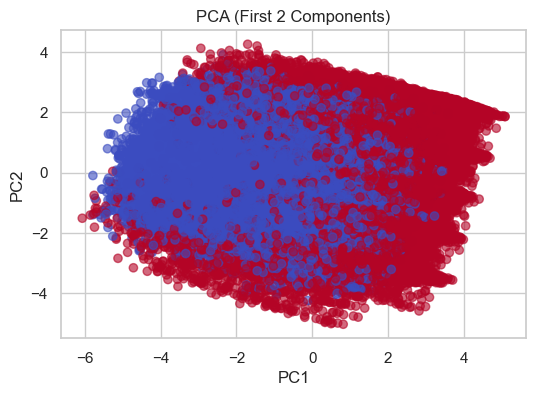

In [33]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import matplotlib.pyplot as plt

pca = PCA(n_components=.95)
X_pca = pca.fit_transform(scaled_x)

print(f"PCA reduced to {X_pca.shape[1]} components")

# Visualize first 2 components
plt.figure(figsize=(6,4))
plt.title("PCA (First 2 Components)")
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', alpha=0.6)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()


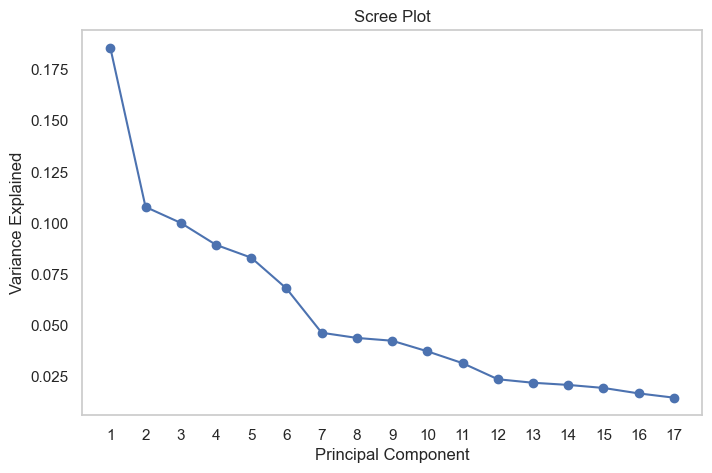

In [34]:
# scree plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.xticks(range(1, len(pca.explained_variance_ratio_) + 1))
plt.grid()
plt.show()

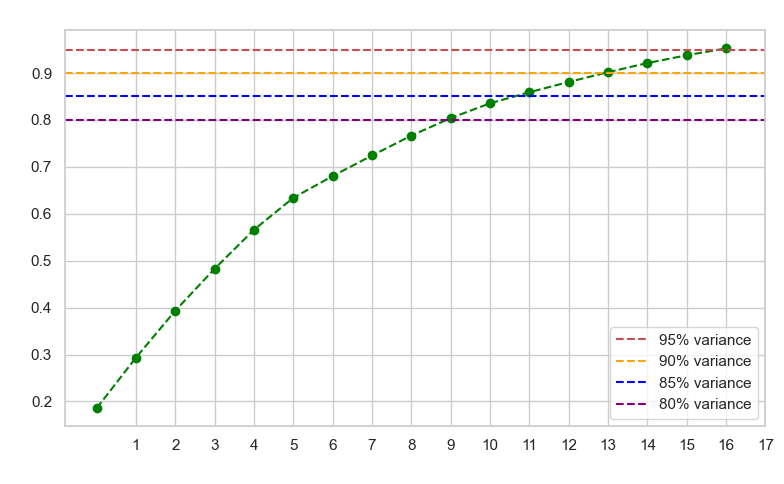

In [35]:
# Cumulative variance plot
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--', color='green')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% variance')
plt.axhline(y=0.90, color='orange', linestyle='--', label='90% variance')
plt.axhline(y=0.85, color='blue', linestyle='--', label='85% variance')
plt.axhline(y=0.80, color='purple', linestyle='--', label='80% variance')

plt.title('Cumulative Explained Variance', color='white')
plt.xlabel('Number of Components', color='white')
plt.ylabel('Cumulative Variance Explained', color='white')
plt.legend()
plt.grid(True)
plt.xticks(range(1, len(pca.explained_variance_ratio_) + 1))
plt.tight_layout()
plt.show()

## conclusion

In [37]:
drop_rf = ['Gender', 'Departure Delay in Minutes', 'Arrival Delay in Minutes', 'Food and drink', 'Gate location', 'Departure/Arrival time convenient']
drop_corr = ['Departure Delay in Minutes', 'Seat comfort', 'Inflight service', 'Cleanliness', 'Ease of Online booking', 'Food and drink']
drop_mi = ['Departure Delay in Minutes','Arrival Delay in Minutes','Departure/Arrival time convenient','Gate location', 'Customer Type', 'Cleanliness', 'Checkin service', 'Food and drink', 'Gender']
drop_forward = ['Gender', 'Age', 'Class', 'Flight Distance', 'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location', 'Food and drink', 'Seat comfort', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']

def drop_features(data, features_to_drop):
    """
    Drop specified features from the DataFrame.
    """
    return data.drop(columns=features_to_drop, axis=1)

def preprocess_data(data):
    """
    Preprocess the data
    """
    data['satisfaction'] = data['satisfaction'].map({'satisfied': 1, 'neutral or dissatisfied': 0})
    data['Gender'] = data['Gender'].map({'Male':1, 'Female':0})
    data['Customer Type'] = data['Customer Type'].map({'Loyal Customer':1, 'disloyal Customer':0})
    data['Type of Travel'] = data['Type of Travel'].map({'Business travel':1, 'Personal Travel':0})
    data['Class'] = data['Class'].map({'Eco':0, 'Eco Plus':1, 'Business':2})
    data['Arrival Delay in Minutes'].fillna(data['Arrival Delay in Minutes'].median(), inplace=True)
    return data

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')  

def prepare(train, test, filter):
    """
    prepare the data for training and testing
    """
    train = train.drop(columns=['Unnamed: 0', 'id'], axis=1)
    test= test.drop(columns=['Unnamed: 0', 'id'], axis=1)
    train = preprocess_data(train)
    train = drop_features(train, filter)

    test = preprocess_data(test)
    test = drop_features(test, filter)


    X_train = train.drop(columns=['satisfaction'], axis=1)
    y_train = train['satisfaction']

    X_test = test.drop(columns=['satisfaction'], axis=1)
    y_test = test['satisfaction']

    return X_train, y_train, X_test, y_test

X_train_lasso, y_train_lasso, X_test_lasso, y_test_lasso = prepare(train_df.copy(), test_df.copy(), drop_rf)
X_train_corr, y_train_corr, X_test_corr, y_test_corr = prepare(train_df.copy(), test_df.copy(), drop_corr)
X_train_mi, y_train_mi, X_test_mi, y_test_mi = prepare(train_df.copy(), test_df.copy(), drop_mi)
X_train_forward, y_train_forward, X_test_forward, y_test_forward = prepare(train_df.copy(), test_df.copy(), drop_forward)

pipline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier()) 
])
pipline_pca = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),
    ('classifier', RandomForestClassifier())
])

pipline.fit(X_train_forward, y_train_forward)
y_pred = pipline.predict(X_test_forward)

print(classification_report(y_test_forward, y_pred))
print(f"Accuracy: {accuracy_score(y_test_forward, y_pred):.4f}")


              precision    recall  f1-score   support

           0       0.95      0.97      0.96     14573
           1       0.96      0.93      0.94     11403

    accuracy                           0.95     25976
   macro avg       0.95      0.95      0.95     25976
weighted avg       0.95      0.95      0.95     25976

Accuracy: 0.9521


# Training/Validation GPU

In [38]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report,accuracy_score
from sklearn.svm import SVC

drop_forward = ['Gender', 'Age', 'Class', 'Flight Distance', 'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location', 'Food and drink', 'Seat comfort', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']

def drop_features(data, features_to_drop):
    """
    Drop specified features from the DataFrame.
    """
    return data.drop(columns=features_to_drop, axis=1)

def preprocess_data(data):
    """
    Preprocess the data
    """
    data['satisfaction'] = data['satisfaction'].map({'satisfied': 1, 'neutral or dissatisfied': 0})
    data['Gender'] = data['Gender'].map({'Male':1, 'Female':0})
    data['Customer Type'] = data['Customer Type'].map({'Loyal Customer':1, 'disloyal Customer':0})
    data['Type of Travel'] = data['Type of Travel'].map({'Business travel':1, 'Personal Travel':0})
    data['Class'] = data['Class'].map({'Eco':0, 'Eco Plus':1, 'Business':2})
    data['Arrival Delay in Minutes'].fillna(data['Arrival Delay in Minutes'].median(), inplace=True)
    return data

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

def prepare(train, test, filter):
    """
    prepare the data for training and testing
    """

    train = train.drop(columns=['Unnamed: 0', 'id'], axis=1)
    test = test.drop(columns=['Unnamed: 0', 'id'], axis=1)
    train = preprocess_data(train)
    train = drop_features(train, filter)

    test = preprocess_data(test)
    test = drop_features(test, filter)


    X_train = train.drop(columns=['satisfaction'], axis=1)
    y_train = train['satisfaction']

    X_test = test.drop(columns=['satisfaction'], axis=1)
    y_test = test['satisfaction']

    return X_train, y_train, X_test, y_test


X_train_forward, y_train_forward, X_test_forward, y_test_forward = prepare(train_df.copy(), test_df.copy(), drop_forward)



pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ])

pipeline.fit_transform(X_train_forward)
pipeline.transform(X_test_forward)


array([[ 0.4727667 ,  0.6708646 ,  1.70980371, ..., -1.03074212,
         1.15643582,  1.30586973],
       [ 0.4727667 ,  0.6708646 , -1.30264581, ..., -0.24047176,
         0.30584786,  1.30586973],
       [-2.11520819,  0.6708646 , -0.54953343, ..., -1.03074212,
        -1.39532804, -0.98025121],
       ...,
       [ 0.4727667 , -1.49061375, -0.54953343, ...,  1.34006895,
         0.30584786, -0.98025121],
       [ 0.4727667 ,  0.6708646 ,  0.20357895, ...,  0.5497986 ,
         1.15643582,  0.54382941],
       [ 0.4727667 , -1.49061375, -0.54953343, ..., -1.82101248,
        -2.24591599, -1.74229153]])

To speed up training we will use the CUML library to train on the gpu and find out the best parameters which we will then use with sklearn to work on the gpu

First we turn the data into a cp array to work with the cuml library

In [ ]:
import cupy as cp

X_train_forward_cupy = cp.asarray(X_train_forward.values.astype(np.float32))
y_train_forward_cupy = cp.asarray(y_train_forward.values.astype(np.float32))
X_test_forward_cupy = cp.asarray(X_test_forward.values.astype(np.float32))
y_test_forward_cupy = cp.asarray(y_test_forward.values.astype(np.float32))

Next we import the cuml SVC module and gridsearchcv

In [ ]:
from cuml.svm import SVC
from cuml.model_selection import GridSearchCV

Note: we do not show different kernals here as the performance does not differ using poly or sigmoid but we will show linear using a specialized module later

In [ ]:
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto', 0.1, 1]
}

# Create a cuML SVC classifier
svc = SVC(max_iter = 100000,kernel = 'rbf')

# Perform GridSearchCV
grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy',verbose=3)
grid_search.fit(X_train_forward_cupy.get(), y_train_forward_cupy.get())

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# Evaluate the best model
best_svc = grid_search.best_estimator_
y_pred = best_svc.predict(X_test_forward_cupy)


Our best accuracy is by setting C to 10 and gamma to 0.1
- Note that setting C any higher will yeild marginallly better results but with diminishing returns and far higher training time

<pre> ```
precision    recall  f1-score   support

         0.0       0.95      0.97      0.96     14573
         1.0       0.97      0.94      0.95     11403

    accuracy                           0.96     25976
   macro avg       0.96      0.95      0.96     25976
weighted avg       0.96      0.96      0.96     25976

Accuracy: 0.9572
```<pre> 

Our accuracy for the model is about 96%

Next we will try the specialized LinearSVC module that cuml provided

In [ ]:
from cuml.svm import LinearSVC

In [ ]:
param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'loss': ['hinge', 'squared_hinge'],
    'fit_intercept': [True, False],
}

linear_svc = LinearSVC(max_iter=1000000)

grid_search = GridSearchCV(linear_svc, param_grid, cv=5, scoring='accuracy', verbose=3)
grid_search.fit(X_train_forward_cupy.get(), y_train_forward_cupy.get())

print("Best hyperparameters:", grid_search.best_params_)

best_linear_svc = grid_search.best_estimator_
y_pred = best_linear_svc.predict(X_test_forward_cupy)

print(classification_report(y_test_forward_cupy.get(), y_pred.get()))
print(f"Accuracy: {accuracy_score(y_test_forward_cupy.get(), y_pred.get()):.4f}")


<pre>```
Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END C=0.1, fit_intercept=True, loss=hinge, penalty=l1;, score=0.872 total time=   0.1s
[CV 2/5] END C=0.1, fit_intercept=True, loss=hinge, penalty=l1;, score=0.871 total time=   0.1s
[CV 3/5] END C=0.1, fit_intercept=True, loss=hinge, penalty=l1;, score=0.869 total time=   0.1s
[CV 4/5] END C=0.1, fit_intercept=True, loss=hinge, penalty=l1;, score=0.873 total time=   0.1s
[CV 5/5] END C=0.1, fit_intercept=True, loss=hinge, penalty=l1;, score=0.878 total time=   0.1s
[CV 1/5] END C=0.1, fit_intercept=True, loss=hinge, penalty=l2;, score=0.872 total time=   0.1s
[CV 2/5] END C=0.1, fit_intercept=True, loss=hinge, penalty=l2;, score=0.870 total time=   0.0s
[CV 3/5] END C=0.1, fit_intercept=True, loss=hinge, penalty=l2;, score=0.870 total time=   0.0s
[CV 4/5] END C=0.1, fit_intercept=True, loss=hinge, penalty=l2;, score=0.873 total time=   0.1s
[CV 5/5] END C=0.1, fit_intercept=True, loss=hinge, penalty=l2;, score=0.879 total time=   0.0s
[CV 1/5] END C=0.1, fit_intercept=True, loss=squared_hinge, penalty=l1;, score=0.870 total time=   0.1s
[CV 2/5] END C=0.1, fit_intercept=True, loss=squared_hinge, penalty=l1;, score=0.868 total time=   0.1s
[CV 3/5] END C=0.1, fit_intercept=True, loss=squared_hinge, penalty=l1;, score=0.868 total time=   0.1s
[CV 4/5] END C=0.1, fit_intercept=True, loss=squared_hinge, penalty=l1;, score=0.870 total time=   0.1s
[CV 5/5] END C=0.1, fit_intercept=True, loss=squared_hinge, penalty=l1;, score=0.875 total time=   0.1s
[CV 1/5] END C=0.1, fit_intercept=True, loss=squared_hinge, penalty=l2;, score=0.870 total time=   0.0s
[CV 2/5] END C=0.1, fit_intercept=True, loss=squared_hinge, penalty=l2;, score=0.868 total time=   0.0s
[CV 3/5] END C=0.1, fit_intercept=True, loss=squared_hinge, penalty=l2;, score=0.869 total time=   0.0s
[CV 4/5] END C=0.1, fit_intercept=True, loss=squared_hinge, penalty=l2;, score=0.871 total time=   0.0s
[CV 5/5] END C=0.1, fit_intercept=True, loss=squared_hinge, penalty=l2;, score=0.876 total time=   0.0s
[CV 1/5] END C=0.1, fit_intercept=False, loss=hinge, penalty=l1;, score=0.696 total time=   0.1s
[CV 2/5] END C=0.1, fit_intercept=False, loss=hinge, penalty=l1;, score=0.687 total time=   0.1s
[CV 3/5] END C=0.1, fit_intercept=False, loss=hinge, penalty=l1;, score=0.687 total time=   0.0s
[CV 4/5] END C=0.1, fit_intercept=False, loss=hinge, penalty=l1;, score=0.686 total time=   0.0s
[CV 5/5] END C=0.1, fit_intercept=False, loss=hinge, penalty=l1;, score=0.693 total time=   0.0s
[CV 1/5] END C=0.1, fit_intercept=False, loss=hinge, penalty=l2;, score=0.696 total time=   0.0s
[CV 2/5] END C=0.1, fit_intercept=False, loss=hinge, penalty=l2;, score=0.686 total time=   0.0s
[CV 3/5] END C=0.1, fit_intercept=False, loss=hinge, penalty=l2;, score=0.686 total time=   0.0s
[CV 4/5] END C=0.1, fit_intercept=False, loss=hinge, penalty=l2;, score=0.687 total time=   0.0s
[2025-05-03 19:11:09.093] [CUML] [warning] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[CV 5/5] END C=0.1, fit_intercept=False, loss=hinge, penalty=l2;, score=0.692 total time=   0.0s
[CV 1/5] END C=0.1, fit_intercept=False, loss=squared_hinge, penalty=l1;, score=0.694 total time=   0.0s
[CV 2/5] END C=0.1, fit_intercept=False, loss=squared_hinge, penalty=l1;, score=0.687 total time=   0.0s
[CV 3/5] END C=0.1, fit_intercept=False, loss=squared_hinge, penalty=l1;, score=0.685 total time=   0.0s
[CV 4/5] END C=0.1, fit_intercept=False, loss=squared_hinge, penalty=l1;, score=0.690 total time=   0.0s
[CV 5/5] END C=0.1, fit_intercept=False, loss=squared_hinge, penalty=l1;, score=0.695 total time=   0.0s
[CV 1/5] END C=0.1, fit_intercept=False, loss=squared_hinge, penalty=l2;, score=0.694 total time=   0.0s
[CV 2/5] END C=0.1, fit_intercept=False, loss=squared_hinge, penalty=l2;, score=0.687 total time=   0.0s
[CV 3/5] END C=0.1, fit_intercept=False, loss=squared_hinge, penalty=l2;, score=0.685 total time=   0.0s
[CV 4/5] END C=0.1, fit_intercept=False, loss=squared_hinge, penalty=l2;, score=0.688 total time=   0.0s
[CV 5/5] END C=0.1, fit_intercept=False, loss=squared_hinge, penalty=l2;, score=0.693 total time=   0.0s
[CV 1/5] END C=1, fit_intercept=True, loss=hinge, penalty=l1;, score=0.872 total time=   0.1s
[CV 2/5] END C=1, fit_intercept=True, loss=hinge, penalty=l1;, score=0.870 total time=   0.1s
[CV 3/5] END C=1, fit_intercept=True, loss=hinge, penalty=l1;, score=0.869 total time=   0.1s
[CV 4/5] END C=1, fit_intercept=True, loss=hinge, penalty=l1;, score=0.873 total time=   0.1s
[CV 5/5] END C=1, fit_intercept=True, loss=hinge, penalty=l1;, score=0.878 total time=   0.1s
[CV 1/5] END C=1, fit_intercept=True, loss=hinge, penalty=l2;, score=0.872 total time=   0.0s
[CV 2/5] END C=1, fit_intercept=True, loss=hinge, penalty=l2;, score=0.870 total time=   0.0s
[CV 3/5] END C=1, fit_intercept=True, loss=hinge, penalty=l2;, score=0.870 total time=   0.0s
[CV 4/5] END C=1, fit_intercept=True, loss=hinge, penalty=l2;, score=0.873 total time=   0.0s
[CV 5/5] END C=1, fit_intercept=True, loss=hinge, penalty=l2;, score=0.879 total time=   0.1s
[CV 1/5] END C=1, fit_intercept=True, loss=squared_hinge, penalty=l1;, score=0.869 total time=   0.1s
[CV 2/5] END C=1, fit_intercept=True, loss=squared_hinge, penalty=l1;, score=0.868 total time=   0.1s
[CV 3/5] END C=1, fit_intercept=True, loss=squared_hinge, penalty=l1;, score=0.869 total time=   0.1s
[CV 4/5] END C=1, fit_intercept=True, loss=squared_hinge, penalty=l1;, score=0.870 total time=   0.1s
[CV 5/5] END C=1, fit_intercept=True, loss=squared_hinge, penalty=l1;, score=0.875 total time=   0.1s
[CV 1/5] END C=1, fit_intercept=True, loss=squared_hinge, penalty=l2;, score=0.869 total time=   0.0s
[CV 2/5] END C=1, fit_intercept=True, loss=squared_hinge, penalty=l2;, score=0.868 total time=   0.0s
[CV 3/5] END C=1, fit_intercept=True, loss=squared_hinge, penalty=l2;, score=0.869 total time=   0.0s
[CV 4/5] END C=1, fit_intercept=True, loss=squared_hinge, penalty=l2;, score=0.871 total time=   0.0s
[CV 5/5] END C=1, fit_intercept=True, loss=squared_hinge, penalty=l2;, score=0.875 total time=   0.0s
[CV 1/5] END C=1, fit_intercept=False, loss=hinge, penalty=l1;, score=0.696 total time=   0.1s
[CV 2/5] END C=1, fit_intercept=False, loss=hinge, penalty=l1;, score=0.686 total time=   0.0s
[CV 3/5] END C=1, fit_intercept=False, loss=hinge, penalty=l1;, score=0.686 total time=   0.0s
[CV 4/5] END C=1, fit_intercept=False, loss=hinge, penalty=l1;, score=0.687 total time=   0.1s
[CV 5/5] END C=1, fit_intercept=False, loss=hinge, penalty=l1;, score=0.693 total time=   0.1s
[CV 1/5] END C=1, fit_intercept=False, loss=hinge, penalty=l2;, score=0.695 total time=   0.0s
[CV 2/5] END C=1, fit_intercept=False, loss=hinge, penalty=l2;, score=0.687 total time=   0.0s
[CV 3/5] END C=1, fit_intercept=False, loss=hinge, penalty=l2;, score=0.686 total time=   0.0s
[CV 4/5] END C=1, fit_intercept=False, loss=hinge, penalty=l2;, score=0.688 total time=   0.0s
[CV 5/5] END C=1, fit_intercept=False, loss=hinge, penalty=l2;, score=0.692 total time=   0.0s
[CV 1/5] END C=1, fit_intercept=False, loss=squared_hinge, penalty=l1;, score=0.693 total time=   0.0s
[CV 2/5] END C=1, fit_intercept=False, loss=squared_hinge, penalty=l1;, score=0.686 total time=   0.0s
[CV 3/5] END C=1, fit_intercept=False, loss=squared_hinge, penalty=l1;, score=0.685 total time=   0.0s
[CV 4/5] END C=1, fit_intercept=False, loss=squared_hinge, penalty=l1;, score=0.689 total time=   0.0s
[CV 5/5] END C=1, fit_intercept=False, loss=squared_hinge, penalty=l1;, score=0.691 total time=   0.0s
[CV 1/5] END C=1, fit_intercept=False, loss=squared_hinge, penalty=l2;, score=0.694 total time=   0.0s
[CV 2/5] END C=1, fit_intercept=False, loss=squared_hinge, penalty=l2;, score=0.687 total time=   0.0s
[CV 3/5] END C=1, fit_intercept=False, loss=squared_hinge, penalty=l2;, score=0.685 total time=   0.0s
[CV 4/5] END C=1, fit_intercept=False, loss=squared_hinge, penalty=l2;, score=0.688 total time=   0.0s
[CV 5/5] END C=1, fit_intercept=False, loss=squared_hinge, penalty=l2;, score=0.693 total time=   0.0s
[CV 1/5] END C=10, fit_intercept=True, loss=hinge, penalty=l1;, score=0.872 total time=   0.1s
[CV 2/5] END C=10, fit_intercept=True, loss=hinge, penalty=l1;, score=0.870 total time=   0.1s
[CV 3/5] END C=10, fit_intercept=True, loss=hinge, penalty=l1;, score=0.870 total time=   0.1s
[CV 4/5] END C=10, fit_intercept=True, loss=hinge, penalty=l1;, score=0.873 total time=   0.1s
[CV 5/5] END C=10, fit_intercept=True, loss=hinge, penalty=l1;, score=0.879 total time=   0.1s
[CV 1/5] END C=10, fit_intercept=True, loss=hinge, penalty=l2;, score=0.872 total time=   0.0s
[CV 2/5] END C=10, fit_intercept=True, loss=hinge, penalty=l2;, score=0.870 total time=   0.0s
[CV 3/5] END C=10, fit_intercept=True, loss=hinge, penalty=l2;, score=0.870 total time=   0.0s
[CV 4/5] END C=10, fit_intercept=True, loss=hinge, penalty=l2;, score=0.873 total time=   0.0s
[CV 5/5] END C=10, fit_intercept=True, loss=hinge, penalty=l2;, score=0.878 total time=   0.1s
[CV 1/5] END C=10, fit_intercept=True, loss=squared_hinge, penalty=l1;, score=0.869 total time=   0.1s
[CV 2/5] END C=10, fit_intercept=True, loss=squared_hinge, penalty=l1;, score=0.867 total time=   0.1s
[CV 3/5] END C=10, fit_intercept=True, loss=squared_hinge, penalty=l1;, score=0.869 total time=   0.1s
[CV 4/5] END C=10, fit_intercept=True, loss=squared_hinge, penalty=l1;, score=0.871 total time=   0.1s
[CV 5/5] END C=10, fit_intercept=True, loss=squared_hinge, penalty=l1;, score=0.874 total time=   0.1s
[CV 1/5] END C=10, fit_intercept=True, loss=squared_hinge, penalty=l2;, score=0.871 total time=   0.0s
[CV 2/5] END C=10, fit_intercept=True, loss=squared_hinge, penalty=l2;, score=0.869 total time=   0.0s
[CV 3/5] END C=10, fit_intercept=True, loss=squared_hinge, penalty=l2;, score=0.868 total time=   0.0s
[CV 4/5] END C=10, fit_intercept=True, loss=squared_hinge, penalty=l2;, score=0.872 total time=   0.0s
[CV 5/5] END C=10, fit_intercept=True, loss=squared_hinge, penalty=l2;, score=0.876 total time=   0.0s
[CV 1/5] END C=10, fit_intercept=False, loss=hinge, penalty=l1;, score=0.696 total time=   0.1s
[CV 2/5] END C=10, fit_intercept=False, loss=hinge, penalty=l1;, score=0.686 total time=   0.0s
[CV 3/5] END C=10, fit_intercept=False, loss=hinge, penalty=l1;, score=0.687 total time=   0.1s
[CV 4/5] END C=10, fit_intercept=False, loss=hinge, penalty=l1;, score=0.688 total time=   0.0s
[CV 5/5] END C=10, fit_intercept=False, loss=hinge, penalty=l1;, score=0.693 total time=   0.1s
[CV 1/5] END C=10, fit_intercept=False, loss=hinge, penalty=l2;, score=0.695 total time=   0.0s
[CV 2/5] END C=10, fit_intercept=False, loss=hinge, penalty=l2;, score=0.686 total time=   0.0s
[CV 3/5] END C=10, fit_intercept=False, loss=hinge, penalty=l2;, score=0.686 total time=   0.0s
[CV 4/5] END C=10, fit_intercept=False, loss=hinge, penalty=l2;, score=0.686 total time=   0.0s
[CV 5/5] END C=10, fit_intercept=False, loss=hinge, penalty=l2;, score=0.692 total time=   0.0s
[CV 1/5] END C=10, fit_intercept=False, loss=squared_hinge, penalty=l1;, score=0.693 total time=   0.0s
[CV 2/5] END C=10, fit_intercept=False, loss=squared_hinge, penalty=l1;, score=0.686 total time=   0.0s
[CV 3/5] END C=10, fit_intercept=False, loss=squared_hinge, penalty=l1;, score=0.685 total time=   0.0s
[CV 4/5] END C=10, fit_intercept=False, loss=squared_hinge, penalty=l1;, score=0.689 total time=   0.0s
[CV 5/5] END C=10, fit_intercept=False, loss=squared_hinge, penalty=l1;, score=0.691 total time=   0.0s
[CV 1/5] END C=10, fit_intercept=False, loss=squared_hinge, penalty=l2;, score=0.694 total time=   0.0s
[CV 2/5] END C=10, fit_intercept=False, loss=squared_hinge, penalty=l2;, score=0.688 total time=   0.0s
[CV 3/5] END C=10, fit_intercept=False, loss=squared_hinge, penalty=l2;, score=0.685 total time=   0.0s
[CV 4/5] END C=10, fit_intercept=False, loss=squared_hinge, penalty=l2;, score=0.689 total time=   0.0s
[CV 5/5] END C=10, fit_intercept=False, loss=squared_hinge, penalty=l2;, score=0.693 total time=   0.0s
Best hyperparameters: {'C': 0.1, 'fit_intercept': True, 'loss': 'hinge', 'penalty': 'l1'}
              precision    recall  f1-score   support

         0.0       0.86      0.91      0.89     14573
         1.0       0.88      0.82      0.85     11403

    accuracy                           0.87     25976
   macro avg       0.87      0.86      0.87     25976
weighted avg       0.87      0.87      0.87     25976

Accuracy: 0.8696
```<pre>

The gridsearch yielded and 87% accuracy which is worse than our rbf kernal and such we will be using the latter

After acquiring the parameters we will then train using sklearn so that our model can work on the cpu

# Training

In [41]:
X_train_forward, y_train_forward, X_test_forward, y_test_forward = prepare(train_df.copy(), test_df.copy(), drop_forward)
pipline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('classifier', SVC(
            C=10,
            gamma=0.1))
])

pipline.fit(X_train_forward, y_train_forward)
y_pred = pipline.predict(X_test_forward)

print(classification_report(y_test_forward, y_pred))
print(f"Accuracy: {accuracy_score(y_test_forward, y_pred):.4f}")

              precision    recall  f1-score   support

           0       0.95      0.97      0.96     14573
           1       0.97      0.93      0.95     11403

    accuracy                           0.96     25976
   macro avg       0.96      0.95      0.96     25976
weighted avg       0.96      0.96      0.96     25976

Accuracy: 0.9568


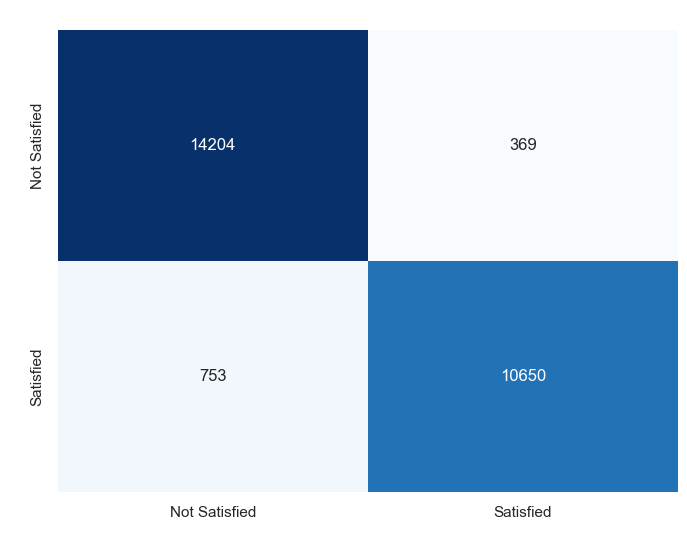

In [43]:
confusion_matrix = confusion_matrix(y_test_forward, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Not Satisfied', 'Satisfied'], yticklabels=['Not Satisfied', 'Satisfied'])
plt.title('Confusion Matrix', color='white')
plt.xlabel('Predicted', color='white')
plt.ylabel('True', color='white')
plt.show()

Our model yeilds the same results which is great

now we save the model pipline to use in our app

In [ ]:
from joblib import dump

dump(pipline,'final.joblib')

['airline_satisfaction_model.joblib']

# App

In [ ]:
import streamlit as st
from streamlit_star_rating import st_star_rating
import pandas as pd
from joblib import load
import numpy as np

# Load model
model = load('final.joblib')

model_features = [
    'Customer Type', 'Type of Travel', 
    'Inflight wifi service', 'Online boarding',
    'Inflight entertainment', 'On-board service',
    'Leg room service', 'Baggage handling', 
    'Checkin service', 'Inflight service', 
    'Cleanliness'
]

st.title('Passenger Satisfaction Predictor')
st.title('✈️✈️✈️✈️✈️✈️✈️✈️✈️✈️✈️')

st.write("""
fill this form to predicts whether passenger is satisfied based on their flight experience.
""")

# form container
with st.form("satisfaction_form"):
    st.subheader("Passenger Information")
    
    col1, col2 = st.columns(2)
    with col1:
        customer_type = st.selectbox('Customer Type', ['Loyal Customer', 'disloyal Customer'], key='customer_type')
    with col2:
        travel_type = st.selectbox('Type of Travel', ['Business travel', 'Personal Travel'], key='travel_type')
    
    st.divider()
    st.subheader("Service Ratings")
    
    ratings_grid = st.columns(2)
    
    with ratings_grid[0]:
        st.write("**Flight Services**")
        wifi = st_star_rating("Inflight wifi service", 5, 3, 20, emoticons=True, key='wifi')
        boarding = st_star_rating("Online boarding", 5, 3, 20, emoticons=True, key='boarding')
        entertainment = st_star_rating("Inflight entertainment", 5, 3, 20, emoticons=True, key='entertainment')
    
    with ratings_grid[1]:
        st.write("**Cabin Services**")
        onboard = st_star_rating("On-board service", 5, 3, 20, emoticons=True, key='onboard')
        legroom = st_star_rating("Leg room service", 5, 3, 20, emoticons=True, key='legroom')
        baggage = st_star_rating("Baggage handling", 5, 3, 20, emoticons=True, key='baggage')
    
    st.divider()
    
    additional_cols = st.columns(3)
    with additional_cols[0]:
        checkin = st_star_rating("Checkin service", 5, 3, 20, emoticons=True, key='checkin')
    with additional_cols[1]:
        inflight = st_star_rating("Inflight service", 5, 3, 20, emoticons=True, key='inflight')
    with additional_cols[2]:
        cleanliness = st_star_rating("Cleanliness", 5, 3, 20, emoticons=True, key='cleanliness')
    
    submitted = st.form_submit_button("Predict Satisfaction", type="primary", use_container_width=True)

if submitted:
    inputs = {
        'Customer Type': customer_type,
        'Type of Travel': travel_type,
        'Inflight wifi service': wifi,
        'Online boarding': boarding,
        'Inflight entertainment': entertainment,
        'On-board service': onboard,
        'Leg room service': legroom,
        'Baggage handling': baggage,
        'Checkin service': checkin,
        'Inflight service': inflight,
        'Cleanliness': cleanliness
    }
    input_df = pd.DataFrame([inputs])
    
    input_df['Customer Type'] = input_df['Customer Type'].map({'Loyal Customer': 1, 'disloyal Customer': 0})
    input_df['Type of Travel'] = input_df['Type of Travel'].map({'Business travel': 1, 'Personal Travel': 0})
    
    input_df = input_df[model_features]
    prediction = model.predict(input_df)
    
    # Get probability
    try:
        probability = model.predict_proba(input_df)[0][1]
    except AttributeError:
        decision = model.decision_function(input_df)
        probability = 1 / (1 + np.exp(-decision))[0]
    
    st.subheader("Prediction Results")
    
    if prediction[0] == 1:
        st.success('✅ Prediction: Satisfied')
    else:
        st.error('❌ Prediction: Neutral or Dissatisfied')
    
    st.metric("Satisfaction Probability", f"{probability:.0%}")
    st.progress(probability)
    
    # Interpretation
    st.write("""
    **Interpretation:**
    - Above 70%: Very likely satisfied
    - 40-70%: Neutral experience
    - Below 40%: Likely dissatisfied
    """)